# Compare growth rates of lineages to their parents

In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from pyrocov import pangolin

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

In [2]:
dataset = torch.load("results/mutrans.data.single.None.pt", map_location="cpu")
print(dataset.keys())
locals().update(dataset)

dict_keys(['location_id', 'mutations', 'weekly_clades', 'features', 'lineage_id', 'lineage_id_inv', 'time_shift'])


In [3]:
lineage_id = {name: i for i, name in enumerate(lineage_id_inv)}

In [4]:
results = torch.load("results/mutrans.final.pt")
for key in results:
    print(key)

('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, ())
('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('include', (('location', '^Europe'),)),))
('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('exclude', (('location', '^Europe'),)),))


In [5]:
best_fit = list(results.values())[0]
print(best_fit.keys())

dict_keys(['median', 'mean', 'std', 'losses', 'series', 'params', 'walltime', 'args', 'mutations'])


In [6]:
best_rate_loc = best_fit["median"]["rate_loc"]

child_to_delta = {}
for c, child in enumerate(lineage_id_inv):
    if child in ("A", "B"):
        continue  # ignore very early lineages
    parent = pangolin.get_parent(pangolin.decompress(child))
    assert parent is not None
    while pangolin.compress(parent) not in lineage_id:
        parent = pangolin.get_parent(parent)
    p = lineage_id[pangolin.compress(parent)]
    parent_rate = best_rate_loc[p].item()
    child_rate = best_rate_loc[c].item()
    child_to_delta[child] = child_rate - parent_rate

child_to_delta = {k: v for k, v in sorted(child_to_delta.items(), key=lambda x: -x[1])}
print("len(child_to_delta): {}".format(len(child_to_delta)))

len(child_to_delta): 1279


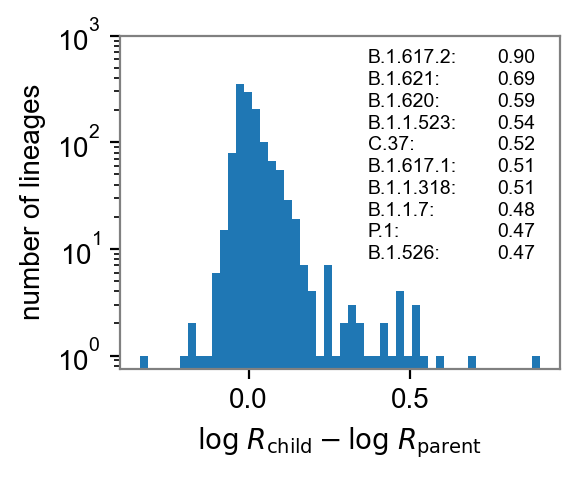

In [8]:
num_annotate = 10
cutoff = list(sorted(child_to_delta.values()))[-num_annotate]
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
ax.hist(child_to_delta.values(), bins=50, log=True)
ax.set_ylim(0.75, 1000)

y_pos = 550.0
for child, delta in child_to_delta.items():
    if delta >= cutoff:
        ax.text(0.37, y_pos, '{}:'.format(child), fontsize=7.)
        ax.text(0.77, y_pos, '{:.2f}'.format(delta), fontsize=7.)
        y_pos /= 1.6

ax.set_xlabel("$\\log \\; R_{\\rm{child}} - \\log \\; R_{\\rm{parent}}$")
ax.set_ylabel("number of lineages")
plt.tight_layout()
plt.savefig('paper/child_parent_Rcomp.png')